In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Paraíba - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PB.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - IDH Longevidade,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - IDH Renda,Paraíba - Consumo de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,0.656510,0.753966,1.938190e+06,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,0.600949,38.426,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,0.656949,0.754445,1.949292e+06,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,0.601441,31.672,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,0.657388,0.754925,1.960394e+06,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,0.601934,28.775,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,0.657827,0.755404,1.971496e+06,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,0.602426,28.571,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,0.658266,0.755883,1.982599e+06,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,0.602918,31.613,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,35014.601037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,34990.882752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,34927.562237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,34834.566845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


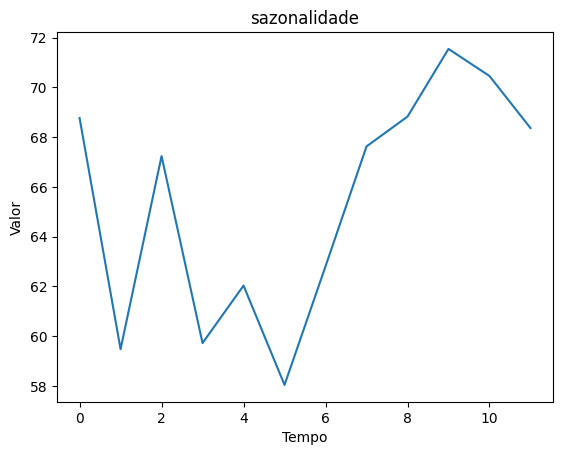

,sazonalidade
sazonalidade,
0,68.767750
1,59.475979
2,67.237995
3,59.720080
4,62.032222
5,58.037799
6,62.807518
7,67.626676
8,68.826271


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - IDH,Paraíba - IDH Longevidade,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Paraíba - PIB - Per Capita,Paraíba - PIB - Preços de Mercado,Paraíba - IDH Renda,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Paraíba - Consumo de Cimento (t)
0,2003-1,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,0.656510,0.753966,1.938190e+06,3.017292e+07,1.631334e+06,7.291169,2.736342e+07,0.600949,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,68.767750,38.426
1,2003-2,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,0.656949,0.754445,1.949292e+06,3.021010e+07,1.632950e+06,7.293438,2.737516e+07,0.601441,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,59.475979,31.672
2,2003-3,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,0.657388,0.754925,1.960394e+06,3.024728e+07,1.634566e+06,7.295708,2.738689e+07,0.601934,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,67.237995,28.775
3,2003-4,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,0.657827,0.755404,1.971496e+06,3.028445e+07,1.636182e+06,7.297978,2.739862e+07,0.602426,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,59.720080,28.571
4,2003-5,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,0.658266,0.755883,1.982599e+06,3.032163e+07,1.637798e+06,7.300247,2.741035e+07,0.602918,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,62.032222,31.613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,35014.601037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.032222,NaN
245,2023-6,34990.882752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.037799,NaN
246,2023-7,34927.562237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.807518,NaN
247,2023-8,34834.566845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.626676,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      32.450
1      27.763
2      30.131
3      27.103
4      28.053
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Paraíba - Consumo de Cimento (t), Length: 249, dtype: float64

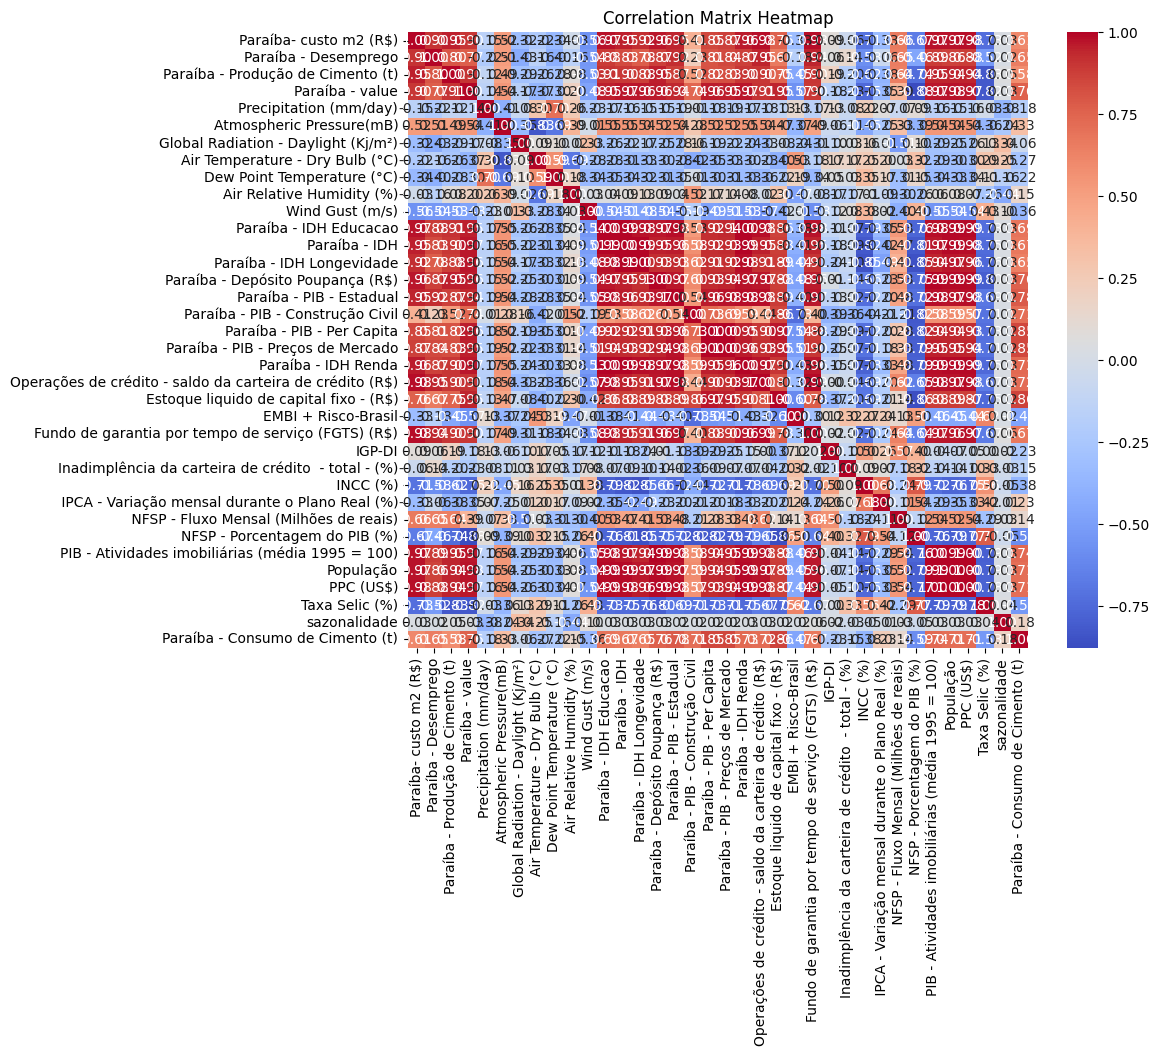

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Paraíba- custo m2 (R$),7.382098e+05
1,Paraíba - Desemprego,5.316541e+04
2,Paraíba - Produção de Cimento (t),6.119003e+04
3,Paraíba - value,1.136028e+05
4,Precipitation (mm/day),2.401192e+02
5,Atmospheric Pressure(mB),3.914853e+07
6,Global Radiation - Daylight (Kj/m²),3.635603e+02
7,Air Temperature - Dry Bulb (°C),2.097745e+06
8,Dew Point Temperature (°C),1.479961e+06
9,Air Relative Humidity (%),1.396725e+06


In [39]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 'Air Relative Humidity (%)',
                 'Paraíba - IDH Longevidade',
                 'Paraíba - IDH Renda',
                 'Paraíba - Depósito Poupança (R$)',
                 'Paraíba - PIB - Estadual', 
                 'Inadimplência da carteira de crédito  - total - (%)',
                 'Paraíba - PIB - Per Capita',
                 'Paraíba - PIB - Preços de Mercado'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 7


,Paraíba- custo m2 (R$),Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,9766.671600,8.315958,118.926160,0.182304,1.190368,948.129859,1343.725535,22.497513,19.371613,84.002026,4.942143,0.592931,1.938190e+06,3.017292e+07,1.631334e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,68.767750
1,9857.678138,8.309895,117.724891,0.185909,1.190430,948.130898,1343.725535,22.497092,19.371751,84.004982,4.939870,0.593396,1.949292e+06,3.021010e+07,1.632950e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,59.475979
2,9943.113694,8.303831,118.501965,0.189593,1.190466,948.131504,1343.725535,22.496846,19.371831,84.006706,4.938543,0.593862,1.960394e+06,3.024728e+07,1.634566e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,67.237995
3,10021.544051,8.297767,119.390679,0.193353,1.190470,948.131569,1343.725535,22.496820,19.371840,84.006891,4.938401,0.594327,1.971496e+06,3.028445e+07,1.636182e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,59.720080
4,10097.066120,8.291704,121.517541,0.197186,1.212656,948.032498,1337.766989,22.616890,19.394367,83.575985,4.915516,0.594792,1.982599e+06,3.032163e+07,1.637798e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,62.032222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,26482.233113,11.188102,252.392677,0.600390,1.020577,949.752951,946.214311,21.750966,18.697714,84.347552,4.136993,0.653535,5.679532e+06,3.548370e+07,1.712141e+06,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,67.626676
200,26707.616317,11.187534,253.907789,0.603823,0.896240,949.114776,1038.806306,22.230226,18.699650,82.337658,4.140643,0.653488,5.758919e+06,3.544701e+07,1.712284e+06,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,68.826271
201,26942.513746,11.186966,257.339105,0.607053,0.842307,948.601180,1097.710247,22.785586,18.833069,80.596912,4.004234,0.653442,5.838306e+06,3.541032e+07,1.712427e+06,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,71.546852
202,27180.876016,11.186399,258.430896,0.610493,0.763798,948.265124,1149.008965,23.351189,19.110917,79.449227,3.840802,0.653395,5.917693e+06,3.537363e+07,1.712570e+06,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,70.457470


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-0.862569,-1.884009,-2.465818,-0.024127,-0.288244,0.970581,-0.132691,0.076852,0.202471,1.445868,-1.944700,-1.730951,-1.774644,-2.553220,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-0.866919,-1.923387,-2.434370,-0.023852,-0.287157,0.970581,-0.133172,0.077073,0.203381,1.440532,-1.920643,-1.720992,-1.756199,-2.504147,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-0.871269,-1.897914,-2.402234,-0.023691,-0.286523,0.970581,-0.133452,0.077202,0.203911,1.437420,-1.896586,-1.711033,-1.737753,-2.455074,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-0.875619,-1.868781,-2.369435,-0.023673,-0.286455,0.970581,-0.133482,0.077216,0.203968,1.437086,-1.872529,-1.701074,-1.719307,-2.406001,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-0.879968,-1.799061,-2.335998,0.074749,-0.390116,0.936758,0.003506,0.113475,0.071354,1.383386,-1.848472,-1.691115,-1.700862,-2.356927,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.197832,2.491123,1.181438,-0.777350,1.410038,-1.285791,-0.984426,-1.007858,0.308809,-0.443448,1.189064,1.625152,0.860348,-0.099318,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,1.197425,2.540790,1.211390,-1.328931,0.742299,-0.760216,-0.437639,-1.004741,-0.309750,-0.434882,1.186658,1.696365,0.842143,-0.094967,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,1.197018,2.653271,1.239568,-1.568188,0.204911,-0.425863,0.195971,-0.789990,-0.845477,-0.754971,1.184253,1.767577,0.823939,-0.090616,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,1.196611,2.689060,1.269573,-1.916469,-0.146713,-0.134679,0.841266,-0.342766,-1.198685,-1.138471,1.181848,1.838790,0.805734,-0.086266,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-0.862569,-1.884009,-2.465818,-0.024127,-0.288244,0.970581,-0.132691,0.076852,0.202471,1.445868,-1.944700,-1.730951,-1.774644,-2.553220,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-0.866919,-1.923387,-2.434370,-0.023852,-0.287157,0.970581,-0.133172,0.077073,0.203381,1.440532,-1.920643,-1.720992,-1.756199,-2.504147,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-0.871269,-1.897914,-2.402234,-0.023691,-0.286523,0.970581,-0.133452,0.077202,0.203911,1.437420,-1.896586,-1.711033,-1.737753,-2.455074,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-0.875619,-1.868781,-2.369435,-0.023673,-0.286455,0.970581,-0.133482,0.077216,0.203968,1.437086,-1.872529,-1.701074,-1.719307,-2.406001,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-0.879968,-1.799061,-2.335998,0.074749,-0.390116,0.936758,0.003506,0.113475,0.071354,1.383386,-1.848472,-1.691115,-1.700862,-2.356927,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.176643,1.417102,0.841763,-1.772161,1.091522,-0.722522,-0.481304,-1.827215,-1.019204,0.205677,1.213333,1.080394,1.037248,-0.169531,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,1.181451,1.478767,0.851832,-1.741695,0.621705,-0.806615,-0.028094,-1.632789,-1.345300,0.150093,1.211846,1.089648,1.027354,-0.161579,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,1.186259,1.590711,0.874924,-1.299611,0.382466,-1.008007,0.490271,-1.314633,-1.655988,0.052464,1.210360,1.098902,1.017460,-0.153628,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,1.191067,1.681244,0.904698,-0.130974,0.120948,-1.278708,0.782657,-0.655225,-1.446045,-0.345460,1.208873,1.108156,1.007566,-0.145676,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       32.450
1       27.763
2       30.131
3       27.103
4       28.053
        ...   
187    106.040
188    103.000
189    103.842
190     95.093
191     94.341
Name: Paraíba - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 26)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Paraíba - Desemprego,Paraíba - Produção de Cimento (t),Paraíba - value,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Paraíba - IDH Educacao,Paraíba - Depósito Poupança (R$),Paraíba - PIB - Estadual,Paraíba - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,1.211626,0.479822,0.840411,0.323354,0.192704,-0.588043,0.313974,1.128960,0.711920,-1.453606,1.302122,0.679918,1.142738,-0.088999,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,1.204127,0.472724,0.845726,0.400373,0.344869,-0.862749,0.136935,1.155660,0.937724,-1.211663,1.301621,0.694062,1.144369,-0.095759,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,1.196629,0.475817,0.851134,0.476494,0.733725,-1.102883,-0.148397,0.945541,1.066110,-1.195623,1.301120,0.708207,1.146000,-0.102520,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,1.189131,0.473584,0.856939,0.166815,1.112101,-1.292181,-0.584216,0.308882,0.996246,-0.954408,1.300619,0.722351,1.147632,-0.109280,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,1.181633,0.440495,0.863506,-0.353979,1.666989,-1.088856,-0.887581,-0.605622,0.536163,-0.696694,1.300118,0.736495,1.149263,-0.116041,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,1.174134,0.461675,0.859492,-1.043949,1.953134,-0.713713,-0.964755,-1.407300,-0.071503,-0.180845,1.299617,0.750639,1.150894,-0.122801,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,1.166636,0.455310,0.854300,-1.182225,1.746257,-0.403278,-0.818918,-1.979417,-0.721223,0.337103,1.299116,0.764783,1.152525,-0.129562,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,1.159138,0.475791,0.850910,-1.633615,1.377413,-0.110836,-0.429070,-2.206622,-1.346913,0.578084,1.298614,0.778928,1.154156,-0.136322,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,1.151639,0.491461,0.850894,-0.699892,0.842797,0.023675,-0.040511,-2.084982,-1.675076,0.621421,1.298113,0.793072,1.155787,-0.143082,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,1.144141,0.497477,0.850154,-0.543723,0.282051,0.090611,0.288350,-1.798961,-1.831802,0.505920,1.297612,0.807216,1.157418,-0.149843,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 26)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.15,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[978425672, 3047920432, 998817726, 3129721978, 35791627]


Step: 0 ___________________________________________
val_loss: 226.42510986328125
winner_seed: 978425672


Step: 1 ___________________________________________
val_loss: 210.49761962890625
winner_seed: 3047920432


Step: 2 ___________________________________________
val_loss: 97.13785552978516
winner_seed: 998817726


Step: 3 ___________________________________________
val_loss: 376.2034606933594


Step: 4 ___________________________________________
val_loss: 329.0859069824219


final_seed: 998817726


In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1037461789

Epoch 1/10000
5/5 [==============================] - 2s 128ms/step - loss: 5258.1216 - val_loss: 529.8194
Epoch 2/10000
5/5 [==============================] - 0s 9ms/step - loss: 516.2700 - val_loss: 374.5345
Epoch 3/10000
5/5 [==============================] - 0s 10ms/step - loss: 431.6652 - val_loss: 402.9560
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 424.2356 - val_loss: 418.5141
Epoch 5/10000
5/5 [==============================] - 0s 11ms/step - loss: 419.6911 - val_loss: 342.6823
Epoch 6/10000
5/5 [==============================] - 0s 10ms/step - loss: 405.0410 - val_loss: 349.5211
Epoch 7/10000
5/5 [==============================] - 0s 9ms/step - loss: 388.9994 - val_loss: 380.2213
Epoch 8/10000
5/5 [==============================] - 0s 10ms/step - loss: 377.5466 - val_loss: 353.1822
Epoch 9/10000
5/5 [==============================] - 0s 10ms/step - loss: 316.5820 - val_loss: 375.3052
Epoch 10/10000
5/5 [==============================] - 0s 10ms/st

Epoch 80/10000
5/5 [==============================] - 0s 10ms/step - loss: 68.0612 - val_loss: 498.3329
Epoch 81/10000
5/5 [==============================] - 0s 10ms/step - loss: 64.8766 - val_loss: 606.1340
Epoch 82/10000
5/5 [==============================] - 0s 11ms/step - loss: 68.4879 - val_loss: 586.5684
Epoch 83/10000
5/5 [==============================] - 0s 10ms/step - loss: 73.0709 - val_loss: 520.2086
Epoch 84/10000
5/5 [==============================] - 0s 10ms/step - loss: 68.1254 - val_loss: 448.7228
Epoch 85/10000
5/5 [==============================] - 0s 11ms/step - loss: 66.1018 - val_loss: 527.8126
Epoch 86/10000
5/5 [==============================] - 0s 11ms/step - loss: 66.7453 - val_loss: 414.5160
Epoch 87/10000
5/5 [==============================] - 0s 9ms/step - loss: 74.7128 - val_loss: 376.3666
Epoch 88/10000
5/5 [==============================] - 0s 9ms/step - loss: 76.2551 - val_loss: 462.8393
Epoch 89/10000
5/5 [==============================] - 0s 9ms/step 

5/5 [==============================] - 0s 10ms/step - loss: 52.7225 - val_loss: 409.5765
Epoch 159/10000
5/5 [==============================] - 0s 10ms/step - loss: 51.8593 - val_loss: 409.1924
Epoch 160/10000
5/5 [==============================] - 0s 11ms/step - loss: 50.0013 - val_loss: 559.0158
Epoch 161/10000
5/5 [==============================] - 0s 10ms/step - loss: 50.9099 - val_loss: 513.2659
Epoch 162/10000
5/5 [==============================] - 0s 10ms/step - loss: 51.5951 - val_loss: 471.1687
Epoch 163/10000
5/5 [==============================] - 0s 11ms/step - loss: 50.1112 - val_loss: 490.1903
Epoch 164/10000
5/5 [==============================] - 0s 11ms/step - loss: 50.7193 - val_loss: 418.1877
Epoch 165/10000
5/5 [==============================] - 0s 11ms/step - loss: 59.1927 - val_loss: 487.3639
Epoch 166/10000
5/5 [==============================] - 0s 11ms/step - loss: 52.1218 - val_loss: 401.7441
Epoch 167/10000
5/5 [==============================] - 0s 10ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 41.7061 - val_loss: 389.2433
Epoch 237/10000
5/5 [==============================] - 0s 11ms/step - loss: 40.2575 - val_loss: 436.5838
Epoch 238/10000
5/5 [==============================] - 0s 12ms/step - loss: 39.7823 - val_loss: 441.8158
Epoch 239/10000
5/5 [==============================] - 0s 10ms/step - loss: 39.6296 - val_loss: 424.2594
Epoch 240/10000
5/5 [==============================] - 0s 11ms/step - loss: 37.7702 - val_loss: 485.9898
Epoch 241/10000
5/5 [==============================] - 0s 10ms/step - loss: 40.1755 - val_loss: 354.1783
Epoch 242/10000
5/5 [==============================] - 0s 10ms/step - loss: 39.7999 - val_loss: 407.3193
Epoch 243/10000
5/5 [==============================] - 0s 11ms/step - loss: 38.2652 - val_loss: 408.4088
Epoch 244/10000
5/5 [==============================] - 0s 11ms/step - loss: 40.5169 - val_loss: 460.4867
Epoch 245/10000
5/5 [==============================] - 0s 10ms/step - l

5/5 [==============================] - 0s 9ms/step - loss: 37.4131 - val_loss: 381.9544
Epoch 315/10000
5/5 [==============================] - 0s 9ms/step - loss: 31.0695 - val_loss: 469.6252
Epoch 316/10000
5/5 [==============================] - 0s 9ms/step - loss: 32.9879 - val_loss: 414.0670
Epoch 317/10000
5/5 [==============================] - 0s 10ms/step - loss: 31.5010 - val_loss: 428.8100
Epoch 318/10000
5/5 [==============================] - 0s 11ms/step - loss: 32.5926 - val_loss: 419.7036
Epoch 319/10000
5/5 [==============================] - 0s 10ms/step - loss: 31.0069 - val_loss: 442.8203
Epoch 320/10000
5/5 [==============================] - 0s 10ms/step - loss: 36.2231 - val_loss: 438.1190
Epoch 321/10000
5/5 [==============================] - 0s 11ms/step - loss: 32.1458 - val_loss: 410.0339
Epoch 322/10000
5/5 [==============================] - 0s 10ms/step - loss: 35.4239 - val_loss: 440.4651
Epoch 323/10000
5/5 [==============================] - 0s 11ms/step - loss

5/5 [==============================] - 0s 10ms/step - loss: 29.4834 - val_loss: 396.2018
Epoch 393/10000
5/5 [==============================] - 0s 10ms/step - loss: 30.5406 - val_loss: 436.4009
Epoch 394/10000
5/5 [==============================] - 0s 11ms/step - loss: 27.9478 - val_loss: 360.2846
Epoch 395/10000
5/5 [==============================] - 0s 10ms/step - loss: 28.4326 - val_loss: 450.2291
Epoch 396/10000
5/5 [==============================] - 0s 10ms/step - loss: 28.1401 - val_loss: 428.5063
Epoch 397/10000
5/5 [==============================] - 0s 10ms/step - loss: 29.2456 - val_loss: 384.6460
Epoch 398/10000
5/5 [==============================] - 0s 9ms/step - loss: 27.9627 - val_loss: 446.3665
Epoch 399/10000
5/5 [==============================] - 0s 10ms/step - loss: 27.7752 - val_loss: 440.4799
Epoch 400/10000
5/5 [==============================] - 0s 11ms/step - loss: 26.7590 - val_loss: 521.0867
Epoch 401/10000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 10ms/step - loss: 28.0980 - val_loss: 503.1261
Epoch 471/10000
5/5 [==============================] - 0s 9ms/step - loss: 25.0095 - val_loss: 451.2508
Epoch 472/10000
5/5 [==============================] - 0s 8ms/step - loss: 23.7240 - val_loss: 486.0045
Epoch 473/10000
5/5 [==============================] - 0s 9ms/step - loss: 26.0276 - val_loss: 477.9916
Epoch 474/10000
5/5 [==============================] - 0s 9ms/step - loss: 31.0800 - val_loss: 468.4088
Epoch 475/10000
5/5 [==============================] - 0s 9ms/step - loss: 26.7143 - val_loss: 504.4522
Epoch 476/10000
5/5 [==============================] - 0s 9ms/step - loss: 25.6246 - val_loss: 396.3041
Epoch 477/10000
5/5 [==============================] - 0s 10ms/step - loss: 23.7676 - val_loss: 394.9016
Epoch 478/10000
5/5 [==============================] - 0s 10ms/step - loss: 24.8067 - val_loss: 425.1992
Epoch 479/10000
5/5 [==============================] - 0s 10ms/step - loss: 2

5/5 [==============================] - 0s 10ms/step - loss: 21.6961 - val_loss: 432.7658
Epoch 549/10000
5/5 [==============================] - 0s 10ms/step - loss: 21.0531 - val_loss: 460.9215
Epoch 550/10000
5/5 [==============================] - 0s 10ms/step - loss: 21.3735 - val_loss: 407.8887
Epoch 551/10000
5/5 [==============================] - 0s 10ms/step - loss: 24.0157 - val_loss: 372.8950
Epoch 552/10000
5/5 [==============================] - 0s 10ms/step - loss: 53.9276 - val_loss: 350.7857
Epoch 553/10000
5/5 [==============================] - 0s 10ms/step - loss: 54.1085 - val_loss: 459.9447
Epoch 554/10000
5/5 [==============================] - 0s 10ms/step - loss: 79.2026 - val_loss: 432.5496
Epoch 555/10000
5/5 [==============================] - 0s 10ms/step - loss: 141.4082 - val_loss: 431.2492
Epoch 556/10000
5/5 [==============================] - 0s 10ms/step - loss: 57.9330 - val_loss: 493.7318
Epoch 557/10000
5/5 [==============================] - 0s 10ms/step - 

5/5 [==============================] - 0s 10ms/step - loss: 20.5881 - val_loss: 443.7116
Epoch 627/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.6844 - val_loss: 414.8265
Epoch 628/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.7571 - val_loss: 464.8578
Epoch 629/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.9440 - val_loss: 506.6165
Epoch 630/10000
5/5 [==============================] - 0s 8ms/step - loss: 21.7889 - val_loss: 470.8683
Epoch 631/10000
5/5 [==============================] - 0s 8ms/step - loss: 19.6242 - val_loss: 490.8645
Epoch 632/10000
5/5 [==============================] - 0s 9ms/step - loss: 21.5947 - val_loss: 442.7275
Epoch 633/10000
5/5 [==============================] - 0s 9ms/step - loss: 19.5743 - val_loss: 510.9820
Epoch 634/10000
5/5 [==============================] - 0s 10ms/step - loss: 19.9309 - val_loss: 477.9977
Epoch 635/10000
5/5 [==============================] - 0s 9ms/step - loss: 19

5/5 [==============================] - 0s 11ms/step - loss: 18.2662 - val_loss: 493.8947
Epoch 705/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.5622 - val_loss: 425.0695
Epoch 706/10000
5/5 [==============================] - 0s 9ms/step - loss: 17.3266 - val_loss: 476.4622
Epoch 707/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.3728 - val_loss: 477.6287
Epoch 708/10000
5/5 [==============================] - 0s 9ms/step - loss: 15.5347 - val_loss: 501.8916
Epoch 709/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.6140 - val_loss: 478.3611
Epoch 710/10000
5/5 [==============================] - 0s 10ms/step - loss: 16.4857 - val_loss: 495.9647
Epoch 711/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.5238 - val_loss: 457.1427
Epoch 712/10000
5/5 [==============================] - 0s 9ms/step - loss: 20.2980 - val_loss: 494.7229
Epoch 713/10000
5/5 [==============================] - 0s 10ms/step - loss: 

5/5 [==============================] - 0s 9ms/step - loss: 29.2161 - val_loss: 501.4496
Epoch 783/10000
5/5 [==============================] - 0s 9ms/step - loss: 28.5486 - val_loss: 494.3042
Epoch 784/10000
5/5 [==============================] - 0s 9ms/step - loss: 256.2654 - val_loss: 594.4177
Epoch 785/10000
5/5 [==============================] - 0s 10ms/step - loss: 150.4118 - val_loss: 473.1464
Epoch 786/10000
5/5 [==============================] - 0s 9ms/step - loss: 79.7482 - val_loss: 506.6400
Epoch 787/10000
5/5 [==============================] - 0s 9ms/step - loss: 56.9139 - val_loss: 498.5381
Epoch 788/10000
5/5 [==============================] - 0s 10ms/step - loss: 45.1151 - val_loss: 238.6378
Epoch 789/10000
5/5 [==============================] - 0s 10ms/step - loss: 75.5473 - val_loss: 399.8662
Epoch 790/10000
5/5 [==============================] - 0s 10ms/step - loss: 42.0126 - val_loss: 442.7147
Epoch 791/10000
5/5 [==============================] - 0s 10ms/step - loss

5/5 [==============================] - 0s 10ms/step - loss: 14.4359 - val_loss: 510.4638
Epoch 861/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.1596 - val_loss: 507.9624
Epoch 862/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.4635 - val_loss: 508.1954
Epoch 863/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.7321 - val_loss: 504.8561
Epoch 864/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.4294 - val_loss: 477.8207
Epoch 865/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.3114 - val_loss: 495.6237
Epoch 866/10000
5/5 [==============================] - 0s 10ms/step - loss: 19.2672 - val_loss: 500.4209
Epoch 867/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.2692 - val_loss: 521.6801
Epoch 868/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.1385 - val_loss: 518.6980
Epoch 869/10000
5/5 [==============================] - 0s 8ms/step - loss

5/5 [==============================] - 0s 10ms/step - loss: 11.6705 - val_loss: 516.8620
Epoch 939/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.5717 - val_loss: 503.8560
Epoch 940/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.0314 - val_loss: 523.2735
Epoch 941/10000
5/5 [==============================] - 0s 11ms/step - loss: 12.0705 - val_loss: 530.4732
Epoch 942/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.3756 - val_loss: 513.9670
Epoch 943/10000
5/5 [==============================] - 0s 11ms/step - loss: 9.8945 - val_loss: 504.8930
Epoch 944/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.2437 - val_loss: 485.3863
Epoch 945/10000
5/5 [==============================] - 0s 9ms/step - loss: 80.6325 - val_loss: 527.8203
Epoch 946/10000
5/5 [==============================] - 0s 9ms/step - loss: 43.4403 - val_loss: 500.3131
Epoch 947/10000
5/5 [==============================] - 0s 9ms/step - loss:

5/5 [==============================] - 0s 9ms/step - loss: 11.3789 - val_loss: 539.3241
Epoch 1017/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.2416 - val_loss: 470.4130
Epoch 1018/10000
5/5 [==============================] - 0s 9ms/step - loss: 97.6587 - val_loss: 448.3194
Epoch 1019/10000
5/5 [==============================] - 0s 10ms/step - loss: 150.7350 - val_loss: 258.4562
Epoch 1020/10000
5/5 [==============================] - 0s 9ms/step - loss: 57.6289 - val_loss: 339.1241
Epoch 1021/10000
5/5 [==============================] - 0s 9ms/step - loss: 49.1570 - val_loss: 314.3174
Epoch 1022/10000
5/5 [==============================] - 0s 10ms/step - loss: 40.5323 - val_loss: 240.4172
Epoch 1023/10000
5/5 [==============================] - 0s 10ms/step - loss: 39.2138 - val_loss: 300.9797
Epoch 1024/10000
5/5 [==============================] - 0s 10ms/step - loss: 42.6359 - val_loss: 362.3002
Epoch 1025/10000
5/5 [==============================] - 0s 10ms/ste

5/5 [==============================] - 0s 10ms/step - loss: 15.7359 - val_loss: 406.6786
Epoch 1094/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.7424 - val_loss: 402.0496
Epoch 1095/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.5013 - val_loss: 420.1861
Epoch 1096/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.6994 - val_loss: 385.7631
Epoch 1097/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.9950 - val_loss: 425.1009
Epoch 1098/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.3225 - val_loss: 431.3004
Epoch 1099/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.4538 - val_loss: 420.3270
Epoch 1100/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.9253 - val_loss: 417.3580
Epoch 1101/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.6914 - val_loss: 429.4394
Epoch 1102/10000
5/5 [==============================] - 0s 9ms/s

Epoch 1171/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.5611 - val_loss: 450.7498
Epoch 1172/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.6200 - val_loss: 455.3092
Epoch 1173/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.2922 - val_loss: 437.0192
Epoch 1174/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.3922 - val_loss: 476.7738
Epoch 1175/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.6465 - val_loss: 442.4650
Epoch 1176/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.1878 - val_loss: 432.7973
Epoch 1177/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.2210 - val_loss: 443.7362
Epoch 1178/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.8056 - val_loss: 438.7384
Epoch 1179/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.6679 - val_loss: 455.8787
Epoch 1180/10000
5/5 [==============================] -

5/5 [==============================] - 0s 10ms/step - loss: 8.1175 - val_loss: 449.3605
Epoch 1250/10000
5/5 [==============================] - 0s 9ms/step - loss: 8.3169 - val_loss: 447.0045
Epoch 1251/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.9802 - val_loss: 399.8879
Epoch 1252/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.8744 - val_loss: 395.1885
Epoch 1253/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.0204 - val_loss: 402.9830
Epoch 1254/10000
5/5 [==============================] - 0s 11ms/step - loss: 7.7459 - val_loss: 411.4904
Epoch 1255/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.4322 - val_loss: 393.6047
Epoch 1256/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.6793 - val_loss: 397.3966
Epoch 1257/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.3981 - val_loss: 412.0722
Epoch 1258/10000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 9ms/step - loss: 6.5427 - val_loss: 367.2666
Epoch 1328/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.5354 - val_loss: 369.4392
Epoch 1329/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.3173 - val_loss: 383.0694
Epoch 1330/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.1080 - val_loss: 410.0893
Epoch 1331/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.1955 - val_loss: 395.8282
Epoch 1332/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.3521 - val_loss: 376.8801
Epoch 1333/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.7829 - val_loss: 385.5099
Epoch 1334/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.6368 - val_loss: 384.5247
Epoch 1335/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.0050 - val_loss: 386.9048
Epoch 1336/10000
5/5 [==============================] - 0s 9ms/step - loss

5/5 [==============================] - 0s 10ms/step - loss: 7.5654 - val_loss: 345.1962
Epoch 1406/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.2707 - val_loss: 376.2646
Epoch 1407/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.4686 - val_loss: 380.1161
Epoch 1408/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.1810 - val_loss: 375.5153
Epoch 1409/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.2856 - val_loss: 384.6976
Epoch 1410/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.0165 - val_loss: 350.9744
Epoch 1411/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.1708 - val_loss: 414.5944
Epoch 1412/10000
5/5 [==============================] - 0s 11ms/step - loss: 6.2523 - val_loss: 389.1367
Epoch 1413/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.3656 - val_loss: 376.9934
Epoch 1414/10000
5/5 [==============================] - 0s 11ms/step - los

5/5 [==============================] - 0s 10ms/step - loss: 4.6027 - val_loss: 347.0799
Epoch 1484/10000
5/5 [==============================] - 0s 10ms/step - loss: 4.6966 - val_loss: 364.6114
Epoch 1485/10000
5/5 [==============================] - 0s 10ms/step - loss: 4.7882 - val_loss: 414.1591
Epoch 1486/10000
5/5 [==============================] - 0s 9ms/step - loss: 4.8787 - val_loss: 374.4602
Epoch 1487/10000
5/5 [==============================] - 0s 11ms/step - loss: 4.8864 - val_loss: 380.1270
Epoch 1488/10000
5/5 [==============================] - 0s 10ms/step - loss: 5.0660 - val_loss: 311.7555
Epoch 1489/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.5743 - val_loss: 415.9515
Epoch 1490/10000
5/5 [==============================] - 0s 11ms/step - loss: 110.9405 - val_loss: 203.1577
Epoch 1491/10000
5/5 [==============================] - 0s 11ms/step - loss: 115.0379 - val_loss: 552.9089
Epoch 1492/10000
5/5 [==============================] - 0s 10ms/step

5/5 [==============================] - 0s 9ms/step - loss: 29.7018 - val_loss: 483.8372
Epoch 1561/10000
5/5 [==============================] - 0s 10ms/step - loss: 30.7120 - val_loss: 409.7255
Epoch 1562/10000
5/5 [==============================] - 0s 10ms/step - loss: 28.5116 - val_loss: 459.7298
Epoch 1563/10000
5/5 [==============================] - 0s 10ms/step - loss: 26.7859 - val_loss: 439.6352
Epoch 1564/10000
5/5 [==============================] - 0s 9ms/step - loss: 25.9444 - val_loss: 461.1749
Epoch 1565/10000
5/5 [==============================] - 0s 10ms/step - loss: 27.2589 - val_loss: 424.9302
Epoch 1566/10000
5/5 [==============================] - 0s 10ms/step - loss: 26.2967 - val_loss: 600.0126
Epoch 1567/10000
5/5 [==============================] - 0s 10ms/step - loss: 26.9722 - val_loss: 505.0834
Epoch 1568/10000
5/5 [==============================] - 0s 9ms/step - loss: 25.4125 - val_loss: 447.1914
Epoch 1569/10000
5/5 [==============================] - 0s 9ms/ste

Epoch 1638/10000
5/5 [==============================] - 0s 10ms/step - loss: 20.8306 - val_loss: 482.5365
Epoch 1639/10000
5/5 [==============================] - 0s 10ms/step - loss: 35.6017 - val_loss: 561.1101
Epoch 1640/10000
5/5 [==============================] - 0s 10ms/step - loss: 27.1113 - val_loss: 462.3210
Epoch 1641/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.7733 - val_loss: 503.1613
Epoch 1642/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.6952 - val_loss: 447.4824
Epoch 1643/10000
5/5 [==============================] - 0s 10ms/step - loss: 20.7646 - val_loss: 529.7934
Epoch 1644/10000
5/5 [==============================] - 0s 10ms/step - loss: 20.9527 - val_loss: 401.3614
Epoch 1645/10000
5/5 [==============================] - 0s 11ms/step - loss: 20.9233 - val_loss: 457.6065
Epoch 1646/10000
5/5 [==============================] - 0s 10ms/step - loss: 19.6387 - val_loss: 482.0696
Epoch 1647/10000
5/5 [========================

5/5 [==============================] - 0s 9ms/step - loss: 13.6816 - val_loss: 481.2540
Epoch 1716/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.8017 - val_loss: 508.8121
Epoch 1717/10000
5/5 [==============================] - 0s 8ms/step - loss: 11.0356 - val_loss: 496.6002
Epoch 1718/10000
5/5 [==============================] - 0s 9ms/step - loss: 10.5865 - val_loss: 462.7082
Epoch 1719/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.0070 - val_loss: 509.0066
Epoch 1720/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.3050 - val_loss: 489.0746
Epoch 1721/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.5259 - val_loss: 485.7363
Epoch 1722/10000
5/5 [==============================] - 0s 10ms/step - loss: 10.4791 - val_loss: 422.1676
Epoch 1723/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.0216 - val_loss: 432.1403
Epoch 1724/10000
5/5 [==============================] - 0s 10ms/ste

5/5 [==============================] - 0s 9ms/step - loss: 8.6667 - val_loss: 509.4734
Epoch 1794/10000
5/5 [==============================] - 0s 9ms/step - loss: 7.9281 - val_loss: 473.9786
Epoch 1795/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.4826 - val_loss: 439.5829
Epoch 1796/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.7069 - val_loss: 481.2336
Epoch 1797/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.6341 - val_loss: 442.8899
Epoch 1798/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.6060 - val_loss: 484.3016
Epoch 1799/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.2452 - val_loss: 484.9211
Epoch 1800/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.7826 - val_loss: 417.8882
Epoch 1801/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.6023 - val_loss: 432.8801
Epoch 1802/10000
5/5 [==============================] - 0s 10ms/step - los

5/5 [==============================] - 0s 9ms/step - loss: 8.1762 - val_loss: 516.6577
Epoch 1872/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.9492 - val_loss: 535.6402
Epoch 1873/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.5780 - val_loss: 529.3639
Epoch 1874/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.1348 - val_loss: 548.9293
Epoch 1875/10000
5/5 [==============================] - 0s 10ms/step - loss: 9.9751 - val_loss: 542.9310
Epoch 1876/10000
5/5 [==============================] - 0s 9ms/step - loss: 11.7780 - val_loss: 516.6218
Epoch 1877/10000
5/5 [==============================] - 0s 10ms/step - loss: 8.9108 - val_loss: 528.6667
Epoch 1878/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.8536 - val_loss: 532.3913
Epoch 1879/10000
5/5 [==============================] - 0s 10ms/step - loss: 7.2985 - val_loss: 508.9926
Epoch 1880/10000
5/5 [==============================] - 0s 10ms/step - l

5/5 [==============================] - 0s 10ms/step - loss: 8.3527 - val_loss: 514.6092
Epoch 1950/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.7886 - val_loss: 518.3073
Epoch 1951/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.7439 - val_loss: 536.7925
Epoch 1952/10000
5/5 [==============================] - 0s 9ms/step - loss: 6.3892 - val_loss: 525.6400
Epoch 1953/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.4621 - val_loss: 528.6415
Epoch 1954/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.5685 - val_loss: 519.9850
Epoch 1955/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.4811 - val_loss: 523.8911
Epoch 1956/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.1668 - val_loss: 519.2719
Epoch 1957/10000
5/5 [==============================] - 0s 10ms/step - loss: 6.1895 - val_loss: 524.9567
Epoch 1958/10000
5/5 [==============================] - 0s 10ms/step - los

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,93.0839,80.051132,78.633286,76.965607,77.099159,81.818924,88.829361,93.322891,97.167084,101.02124,102.473572,99.515984
Target,96.375,84.138,94.985,88.837,84.853,90.095,97.783,93.27,99.708,99.061,90.117,92.865
Error,3.2911,4.086868,16.351715,11.871391,7.753838,8.276077,8.953636,0.052895,2.540916,1.960243,12.356575,6.650986


In [54]:
display(mae)
display(mape)

7.0121865

0.07649045

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[1069.982]] - Target[1112.087]| =  Error: [[42.10498]]; MAPE:[[0.03786123]]


[array([[42.10498]], dtype=float32)]

42.10498

0.037861228